In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor(), download=True)


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw




Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Processing...


C:\Users\Computer Store\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
# Data Loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# DEFINE RNN
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        # note: batch_first=True
        # applies the convention that our data will be of shape: (num_samples, sequence_length, num_features)
        # rather than: (sequence_length, num_samples, num_features)
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer, we don't need those now
        out, _ = self.rnn(X, (h0, c0))
        
        # we only want h(T) at the final time step
        # N x M => N x K
        out = self.fc(out[:, -1, :])
        return out

In [8]:
model = RNN(28, 128, 2, 10)

In [9]:
device = torch.device('cuda:0')
model.to(device)

RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
# Loss adn optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# Train the model
n_epochs = 10

# stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
    
for i in range(n_epochs):
        
    train_loss = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Reshape the input
        inputs = inputs.view(-1, 28, 28)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())  
    train_loss = np.mean(train_loss)
        
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Reshape the input
        inputs = inputs.view(-1, 28, 28)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
        
    train_losses[i] = train_loss
    test_losses[i] = test_loss
        
    print(f'Epoch {i+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 1/10, Train Loss: 0.1083, Test Loss: 0.1995
Epoch 2/10, Train Loss: 0.0064, Test Loss: 0.1101
Epoch 3/10, Train Loss: 0.0029, Test Loss: 0.0699
Epoch 4/10, Train Loss: 0.0027, Test Loss: 0.0549
Epoch 5/10, Train Loss: 0.0028, Test Loss: 0.0404
Epoch 6/10, Train Loss: 0.0008, Test Loss: 0.0293
Epoch 7/10, Train Loss: 0.0005, Test Loss: 0.0235
Epoch 8/10, Train Loss: 0.0012, Test Loss: 0.0233
Epoch 9/10, Train Loss: 0.0003, Test Loss: 0.0220
Epoch 10/10, Train Loss: 0.0003, Test Loss: 0.0167


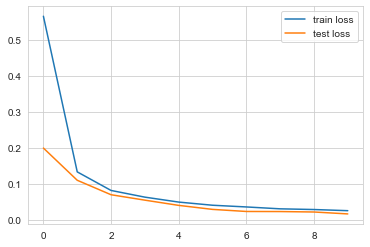

In [15]:
# Plot the train loss and test loss
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [16]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    inputs = inputs.view(-1, 28, 28)
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    inputs = inputs.view(-1, 28, 28)
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

Train accuracy: 0.9923, Test accuracy: 0.9974


In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix is Normalized')
    else:
        print('Confusion Matrix was normalized before')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Confusion Matrix was normalized before
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    3 1027    1    0    0    0    1    0    0]
 [   0    0    0 1006    0    4    0    0    0    0]
 [   0    1    0    0  976    0    0    0    0    5]
 [   0    0    0    0    0  892    0    0    0    0]
 [   2    5    0    0    0    1  950    0    0    0]
 [   0    0    0    0    0    0    0 1028    0    0]
 [   0    0    0    1    0    0    0    0  972    1]
 [   0    1    0    0    0    0    0    0    0 1008]]


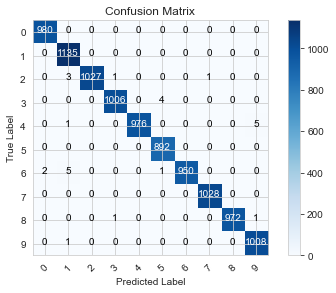

In [19]:
# get all predictions in an array and plot confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    inputs = inputs.view(-1, 28, 28)
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [20]:
# Label mapping
labels = '''0
1
2
3
4
5
6
7
8
9'''.split('\n')

Text(0.5, 1.0, 'True Label: 3  Predicted: 5')

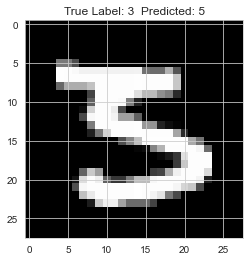

In [34]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title('True Label: %s  Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))